In [1]:
from collections import defaultdict
from collections.abc import Callable

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from simplexity.generative_processes.generalized_hidden_markov_model import GeneralizedHiddenMarkovModel
from simplexity.generative_processes.hidden_markov_model import HiddenMarkovModel
from simplexity.generative_processes.mixed_state_presentation import (
    MixedStateTree,
    MixedStateTreeGenerator,
    NodeDictValue,
    SearchAlgorithm,
)

In [2]:
class Entropies(eqx.Module):
    """Entropies of a generative process."""
    belief_state_entropy: jax.Array
    obs_entropy: jax.Array

In [3]:
def get_node_vals_by_seq_len(tree: MixedStateTree) -> dict[int, list[NodeDictValue]]:
    """Group node values into lists by sequence length."""
    node_vals_by_seq_len = defaultdict(list)
    for sequence, values in tree.nodes.items():
        k = len(sequence)
        node_vals_by_seq_len[k].append(values)
    return node_vals_by_seq_len

In [4]:
def validate_node_vals_by_seq_len(node_vals_by_seq_len: dict[int, list[NodeDictValue]], num_obs: int) -> None:
    """Check for the expected number of node values for each sequence length."""
    max_sequence_length = max(node_vals_by_seq_len.keys())
    assert set(node_vals_by_seq_len.keys()) == set(range(max_sequence_length + 1))
    assert all(len(node_vals_by_seq_len[length]) == num_obs ** length for length in node_vals_by_seq_len)

In [5]:
def validate_log_probs(log_probs: jax.Array) -> None:
    """Validate that the total probability of a log probability array is 1."""
    log_total_prob = jax.nn.logsumexp(log_probs)
    assert jnp.allclose(log_total_prob, 0, atol=1e-7)

In [6]:
def log_weighted_average(log_values: jax.Array, log_probs: jax.Array) -> jax.Array:
    """Compute the weighted average of a log probability distribution."""
    return jax.nn.logsumexp(log_probs + log_values, axis=0)

In [7]:
def entropy(log_probs: jax.Array) -> jax.Array:
    """Compute the entropy of a log probability distribution."""
    terms = -jnp.exp(log_probs) * log_probs
    terms = jnp.where(jnp.isnan(terms), jnp.zeros_like(terms), terms)
    return jnp.sum(terms)

In [8]:
def compute_entropies_from_nodes(
        node_vals_by_seq_len: dict[int, list[NodeDictValue]], log_obs_dist_fn: Callable[[jax.Array], jax.Array]
    ) -> Entropies:
    """Compute the entropies as a function of sequence length for a generative process from its mixed state nodes."""
    max_sequence_length = max(node_vals_by_seq_len.keys())
    belief_state_entropy = jnp.zeros(max_sequence_length + 1)
    obs_entropy = jnp.zeros(max_sequence_length + 1)

    for sequence_length, node_values in node_vals_by_seq_len.items():
        log_probs = jnp.array([node_values.log_probability for node_values in node_values])
        validate_log_probs(log_probs)
        log_belief_state_dists = jnp.stack([jnp.array(node_values.log_belief_state) for node_values in node_values])
        log_obs_dists = log_obs_dist_fn(log_belief_state_dists)
        log_belief_state_entropies = eqx.filter_vmap(entropy)(log_belief_state_dists)
        log_belief_state_entropy = log_weighted_average(log_belief_state_entropies, log_probs).item()
        log_obs_entropies = eqx.filter_vmap(entropy)(log_obs_dists)
        log_obs_entropy = log_weighted_average(log_obs_entropies, log_probs).item()
        belief_state_entropy = belief_state_entropy.at[sequence_length].set(log_belief_state_entropy)
        obs_entropy = obs_entropy.at[sequence_length].set(log_obs_entropy)

    return Entropies(belief_state_entropy, obs_entropy)

In [9]:
def compute_entropies(ghmm: GeneralizedHiddenMarkovModel, max_sequence_length: int) -> Entropies:
    """Compute the entropies as a function of sequence length for a generative process."""
    generator = MixedStateTreeGenerator(ghmm, max_sequence_length)
    tree = generator.generate(SearchAlgorithm.DEPTH_FIRST)
    node_vals_by_seq_len = get_node_vals_by_seq_len(tree)
    validate_node_vals_by_seq_len(node_vals_by_seq_len, ghmm.num_observations)
    log_obs_dist_fn = eqx.filter_vmap(ghmm.log_observation_probability_distribution)
    return compute_entropies_from_nodes(node_vals_by_seq_len, log_obs_dist_fn)

In [10]:
def plot_entropies(entropies: Entropies, title: str = "") -> None:
    """Plot the entropies of a generative process."""
    sequence_lengths = list(range(len(entropies.belief_state_entropy)))

    def format_axes(ax: Axes) -> None:
        ax.set_title(title)
        ax.set_xlabel("Sequence Length")
        ax.minorticks_off()
        ax.set_xticks(sequence_lengths)
        ax.set_xticklabels(map(str, sequence_lengths))
        ax.set_ylim(bottom=0)

    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(entropies.belief_state_entropy, marker="o")
    axs[0].set_ylabel("Belief State Entropy")
    format_axes(axs[0])
    axs[1].plot(entropies.obs_entropy, marker="o")
    axs[1].set_ylabel("Observation Entropy")
    format_axes(axs[1])
    plt.show()

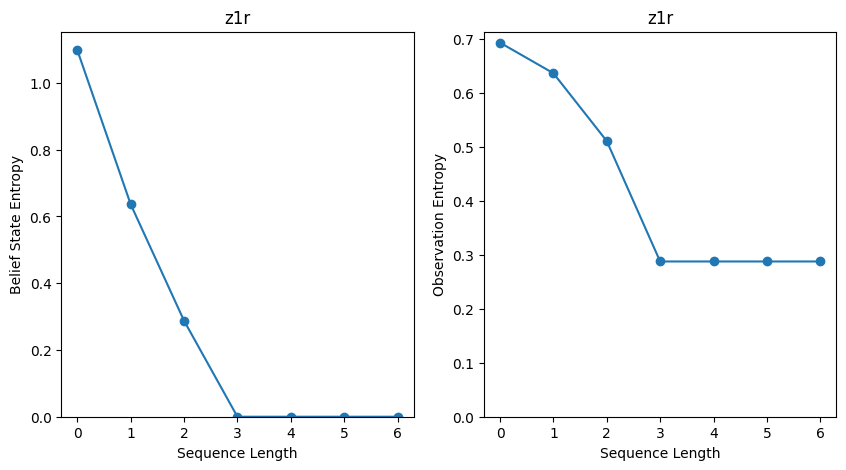

In [11]:
from simplexity.generative_processes.transition_matrices import zero_one_random  # noqa: E402

transition_matrices = zero_one_random()
hmm = HiddenMarkovModel(transition_matrices)
entropies = compute_entropies(hmm, max_sequence_length=6)
plot_entropies(entropies, title="z1r")

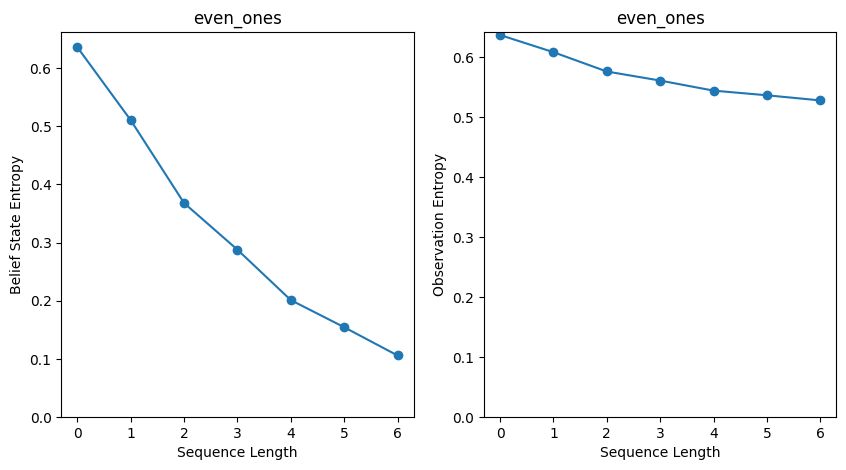

In [12]:
from simplexity.generative_processes.transition_matrices import even_ones  # noqa: E402

transition_matrices = even_ones()
hmm = HiddenMarkovModel(transition_matrices)
entropies = compute_entropies(hmm, max_sequence_length=6)
plot_entropies(entropies, title="even_ones")